In [10]:
import os
import glob
import math
import obspy
import time
import math
from obspy.clients.iris import Client
client = Client()
from matplotlib import pyplot as plt, patches
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output
import numpy as np
from sklearn.decomposition import PCA

In [11]:
ddir = f"C:/Users/youzh/Documents/My documents(not synced)/sP_Workflow"
data_sac = f"{ddir}/Download/SAC"
wdir = f"{ddir}/Download/Verified"

if not os.path.exists(wdir):
    os.mkdir(wdir)

In [12]:
def set_window(st, Tp, TsPmP, TsPn, Twbefore=3, Twafter=2, Tpbefore=0.3, Tplen=0.6, Tspmbefore=0.3, Tspmlen=0.6, Tspnbefore=0.3, Tspnlen=0.6):
    '''
    set the proper time window to verify sP depth phase.
    st -- data streams
    Twbefore -- time before P-wave
    Twafter -- time after P-wave
    Txbefore -- time before x phase
    Txlen -- window length for x phase
    '''
    
    t = np.arange(st[0].stats.sac.t1-Twbefore, st[0].stats.sac.t1+(max(TsPmP,TsPn)-Tp+Twafter), st[0].stats.delta)
    
    idxw1 = int((st[0].stats.sac.t1-Twbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxw2 = int((st[0].stats.sac.t1+(max(TsPmP,TsPn)-Tp+Twafter)-st[0].stats.sac.b)/st[0].stats.delta)
    idxp1 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxp2 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore+Tplen-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm1 = int((st[0].stats.sac.t1+TsPmP-Tp-Tspmbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm2 = int((st[0].stats.sac.t1+TsPmP-Tp-Tspmbefore+Tspmlen-st[0].stats.sac.b)/st[0].stats.delta)
    fig = plt.figure(figsize=(30,15))
    
    if len(t) != len(st[2].data[idxw1:idxw2]):
        t = np.arange(st[0].stats.sac.t1-Twbefore, st[0].stats.sac.t1+(max(TsPmP,TsPn)-Tp+Twafter)-st[0].stats.delta, st[0].stats.delta)
    ax1 = fig.add_subplot(311)
    ax1.plot(t,st[2].data[idxw1:idxw2],color="black",label="Z-Component")
    
    ax1.axvline(x=st[2].stats.sac.t1, color="red", alpha=0.5, linewidth=2,label="Predicted")
    ax1.axvline(x=Tp+st[0].stats.sac.o, color="blue", alpha=0.5, linewidth=2,label="Refined")
    
    ax1.set_xticks(np.arange(min(t), max(t)+0.1, 0.1))
    upperY = 1.2*max(st[2].data[idxw1:idxw2])
    lowerY = 1.2*min(st[2].data[idxw1:idxw2])
    ax1.set_ylim([upperY, lowerY])
    
    hei = max(abs(st[2].data[idxp1:idxp2]))
    rect = patches.Rectangle((Tp+st[0].stats.sac.o-Tpbefore, -1.8*hei), Tplen, 3.6*hei, color='blue',alpha=0.1)
    
    ax1.add_patch(rect)
    
    ax1.axvline(x=TsPmP-Tp, color="green", alpha=0.5, linewidth=2, label="sPmP")
    hei = max(abs(st[2].data[idxspm1:idxspm2]))
    rect = patches.Rectangle((TsPmP-Tp-Tspmbefore, -1.8*hei), Tspmlen, 3.6*hei, color='green',alpha=0.1)
    ax1.add_patch(rect)
    
    #if TsPn != float('nan'):
    if (math.isnan(TsPn)) != True:
        print("TsPn if statement:", TsPn, type(TsPn),float('nan'))
        ax1.axvline(x=TsPn-Tp, color="cyan", alpha=0.5, linewidth=2, label="sPn")
        idxspn1 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)
        hei = max(abs(st[2].data[idxspn1:idxspn2]))
        rect = patches.Rectangle((TsPn-Tp-Tspnbefore, -1.8*hei), Tspnlen, 3.6*hei, color='cyan',alpha=0.1)
        ax1.add_patch(rect)
    ax1.legend(loc="upper left")
    ax1.set_ylabel("Amplitude",fontsize=15)
    ax1.grid()
    

    ax2 = fig.add_subplot(312)
    ax2.plot(t,st[0].data[idxw1:idxw2],color="black",label="R-Component")
    ax2.axvline(x=Tp+st[0].stats.sac.o, color="blue", alpha=0.5, linewidth=2)
    hei = max(abs(st[0].data[idxp1:idxp2]))
    rect = patches.Rectangle((Tp+st[0].stats.sac.o-Tpbefore, -1.8*hei), Tplen, 3.6*hei, color='blue',alpha=0.1)
    ax2.add_patch(rect)
    ax2.axvline(x=TsPmP-Tp, color="green", alpha=0.5, linewidth=2)
    
    ax2.set_ylim([upperY, lowerY])
    ax2.set_xticks(np.arange(min(t), max(t)+0.1, 0.1))
    
    hei = max(abs(st[0].data[idxspm1:idxspm2]))
    rect = patches.Rectangle((TsPmP-Tp-Tspmbefore, -1.8*hei), Tspmlen, 3.6*hei, color='green',alpha=0.1)
    ax2.add_patch(rect)
    #if TsPn != "nan":
    if (math.isnan(TsPn)) != True:
        ax2.axvline(x=TsPn-Tp, color="cyan", alpha=0.5, linewidth=2)
        idxspn1 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)
        hei = max(abs(st[0].data[idxspn1:idxspn2]))
        rect = patches.Rectangle((TsPn-Tp-Tspnbefore, -1.8*hei), Tspnlen, 3.6*hei, color='cyan',alpha=0.1)
        ax2.add_patch(rect)
    ax2.legend(loc="upper left")
    ax2.set_ylabel("Amplitude",fontsize=15)
    ax2.grid()

    ax3 = fig.add_subplot(313)
    ax3.plot(t,st[1].data[idxw1:idxw2],color="black",label="T-Component")
    ax3.axvline(x=Tp+st[0].stats.sac.o, color="blue", alpha=0.5, linewidth=2)
    
    ax3.set_ylim([upperY, lowerY])
    ax3.set_xticks(np.arange(min(t), max(t)+0.1, 0.1))
    
    hei = max(abs(st[1].data[idxp1:idxp2]))
    rect = patches.Rectangle((Tp+st[0].stats.sac.o-Tpbefore, -1.8*hei), Tplen, 3.6*hei, color='blue',alpha=0.1)
    ax3.add_patch(rect)
    ax3.axvline(x=TsPmP-Tp, color="green", alpha=0.5, linewidth=2)
    hei = max(abs(st[1].data[idxspm1:idxspm2]))
    rect = patches.Rectangle((TsPmP-Tp-Tspmbefore, -1.8*hei), Tspmlen, 3.6*hei, color='green',alpha=0.1)
    ax3.add_patch(rect)
    #if TsPn != "nan":
    if (math.isnan(TsPn)) != True:
        ax3.axvline(x=TsPn-Tp, color="cyan", alpha=0.5, linewidth=2)
        idxspn1 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)
        hei = max(abs(st[1].data[idxspn1:idxspn2]))
        rect = patches.Rectangle((TsPn-Tp-Tspnbefore, -1.8*hei), Tspnlen, 3.6*hei, color='cyan',alpha=0.1)
        ax3.add_patch(rect)
    ax3.legend(loc="upper left")
    ax3.set_xlabel("Time (s)",fontsize=15)
    ax3.set_ylabel("Amplitude",fontsize=15)
    ax3.grid()
    
    #axes.set_xticks
    
    
    

    fig.suptitle(f'Set Up Time Window\n(Pbefore:{Tpbefore}s, Plen:{Tplen}s, sPmPbefore:{Tspmbefore}s, sPmPlen:{Tspmlen}s, sPnbefore:{Tspnbefore}s, sPnlen:{Tspnlen}s)',fontsize=20)
    plt.show()
    return fig

In [13]:
def func(pct, allvals):
    absolute = pct*np.sum(allvals)
    return "{:.1f}%\n({:.2e})".format(pct, absolute)

def vef_amp(st, Tp, TsPmP, TsPn, Tpbefore=0.3, Tplen=0.6, Tspmbefore=0.3, Tspmlen=0.6, Tspnbefore=0.3, Tspnlen=0.6):
    
    idxp1 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxp2 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore+Tplen-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm1 = int((st[0].stats.sac.t1+TsPmP-Tp-Tspmbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm2 = int((st[0].stats.sac.t1+TsPmP-Tp-Tspmbefore+Tspmlen-st[0].stats.sac.b)/st[0].stats.delta)

    zamp_p = max(abs(st[2].data[idxp1:idxp2]))
    ramp_p = max(abs(st[0].data[idxp1:idxp2]))
    tamp_p = max(abs(st[1].data[idxp1:idxp2]))

    zamp_spm = max(abs(st[2].data[idxspm1:idxspm2]))
    ramp_spm = max(abs(st[0].data[idxspm1:idxspm2]))
    tamp_spm = max(abs(st[1].data[idxspm1:idxspm2]))

    fig = plt.figure(figsize =(12, 4))

    ax1 = fig.add_subplot(131)
    bars = ['Z-P', 'R-P', 'T-P']
    data = [zamp_p, ramp_p, tamp_p]
    ax1.pie(data, labels = bars, autopct = lambda pct: func(pct, data))

    ax2 = fig.add_subplot(132)
    bars = ['Z-sPmP', 'R-sPmP', 'T-sPmP']
    data = [zamp_spm, ramp_spm, tamp_spm]
    ax2.pie(data, labels = bars, autopct = lambda pct: func(pct, data))

    if (math.isnan(TsPn)) != True:
        idxspn1 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)

        zamp_spn = max(abs(st[2].data[idxspn1:idxspn2]))
        ramp_spn = max(abs(st[0].data[idxspn1:idxspn2]))
        tamp_spn = max(abs(st[1].data[idxspn1:idxspn2]))

        ax3 = fig.add_subplot(133)
        bars = ['Z-sPn', 'R-sPn', 'T-sPn']
        data = [zamp_spn, ramp_spn, tamp_spn]
        ax3.pie(data, labels = bars, autopct = lambda pct: func(pct, data))
        ratio2 = "{:.1f}".format(zamp_spn/zamp_p)

    ratio1 = "{:.1f}".format(zamp_spm/zamp_p)
    if (math.isnan(TsPn)) != True:
        fig.suptitle(f'Verify Amplitude\n (ZsPmP/ZP={ratio1}, ZsPn/ZP={ratio2})',fontsize=20)
    else:
        fig.suptitle(f'Verify Amplitude\n (ZsPmP/ZP={ratio1}',fontsize=20)
    
    plt.show()
    return fig


In [14]:
def vef_polaz(st, Tp, TsPmP, TsPn, Tpbefore=0.3, Tplen=0.6, Tspmbefore=0.3, Tspmlen=0.6, Tspnbefore=0.3, Tspnlen=0.6):
    
    idxp1 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxp2 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore+Tplen-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm1 = int((st[0].stats.sac.t1+TsPmP-Tp-Tspmbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm2 = int((st[0].stats.sac.t1+TsPmP-Tp-Tspmbefore+Tspmlen-st[0].stats.sac.b)/st[0].stats.delta)

    maxp = max(max(abs(st[2].data[idxp1:idxp2])),max(abs(st[0].data[idxp1:idxp2])),max(abs(st[1].data[idxp1:idxp2])))
    z_p = st[2].data[idxp1:idxp2]/maxp
    r_p = st[0].data[idxp1:idxp2]/maxp
    t_p = st[1].data[idxp1:idxp2]/maxp

    maxspm = max(max(abs(st[2].data[idxspm1:idxspm2])),max(abs(st[0].data[idxspm1:idxspm2])),max(abs(st[1].data[idxspm1:idxspm2])))
    z_spm = st[2].data[idxspm1:idxspm2]/maxspm
    r_spm = st[0].data[idxspm1:idxspm2]/maxspm
    t_spm = st[1].data[idxspm1:idxspm2]/maxspm

    fig = plt.figure(figsize =(10, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(331)
    ax1.axis('equal')
    ax1.plot(z_p, r_p, color="black", label="P")
    
    X = np.column_stack((z_p, r_p))
    pca = PCA(n_components=1)
    pca.fit(X)
    angle = math.degrees(math.atan(pca.components_[0][1]/pca.components_[0][0]))
    ax1.quiver(0,0,pca.components_[0][0],pca.components_[0][1],angles=angle, scale=0.5, pivot="middle", headwidth=0, width=0.03, alpha=0.8, color="red")
    if angle < 0:
        angle1 = "{:.0f}".format(180+angle)
    else:
        angle1 = "{:.0f}".format(angle)

    ax1.set_xlabel("Z",fontsize=15)
    ax1.set_ylabel("R",fontsize=15)
    ax1.set_xlim(-1,1)
    ax1.set_ylim(-1,1)
    ax1.grid()
    ax1.tick_params(top=True, bottom=False)
    ax1.tick_params(labeltop=True, labelbottom=False)
    ax1.legend(loc="upper left")

    ax2 = fig.add_subplot(332)
    ax2.axis('equal')
    ax2.plot(z_p, t_p, color="black", label="P")
    ax2.set_xlabel("Z",fontsize=15)
    ax2.set_ylabel("T",fontsize=15)
    ax2.set_xlim(-1,1)
    ax2.set_ylim(-1,1)
    ax2.grid()
    ax2.set_yticklabels([])
    ax2.tick_params(top=True, bottom=False)
    ax2.tick_params(labeltop=True, labelbottom=False)
    ax2.legend(loc="upper left")

    ax3 = fig.add_subplot(333)
    ax3.axis('equal')
    ax3.plot(r_p, t_p, color="black", label="P")
    ax3.set_xlabel("R",fontsize=15)
    ax3.set_ylabel("T",fontsize=15)
    ax3.set_xlim(-1,1)
    ax3.set_ylim(-1,1)
    ax3.grid()
    ax3.set_yticklabels([])
    ax3.tick_params(top=True, bottom=False)
    ax3.tick_params(labeltop=True, labelbottom=False)
    ax3.legend(loc="upper left")

    ax4 = fig.add_subplot(334)
    ax4.axis('equal')
    ax4.plot(z_spm, r_spm, color="black", label="sPmP")

    X = np.column_stack((z_spm, r_spm))
    pca = PCA(n_components=1)
    pca.fit(X)
    angle = math.degrees(math.atan(pca.components_[0][1]/pca.components_[0][0]))
    ax4.quiver(0,0,pca.components_[0][0],pca.components_[0][1],angles=angle, scale=0.5, pivot="middle", headwidth=0, width=0.03, alpha=0.8, color="red")
    if angle < 0:
        angle2 = "{:.0f}".format(180+angle)
    else:
        angle2 = "{:.0f}".format(angle)

    ax4.set_xlabel("Z",fontsize=15)
    ax4.set_ylabel("R",fontsize=15)
    ax4.set_xlim(-1,1)
    ax4.set_ylim(-1,1)
    ax4.grid()
    ax4.set_xticklabels([])
    ax4.legend(loc="upper left")

    ax5 = fig.add_subplot(335)
    ax5.axis('equal')
    ax5.plot(z_spm, t_spm, color="black", label="sPmP")
    ax5.set_xlabel("Z",fontsize=15)
    ax5.set_ylabel("T",fontsize=15)
    ax5.set_xlim(-1,1)
    ax5.set_ylim(-1,1)
    ax5.grid()
    ax5.set_yticklabels([])
    ax5.set_xticklabels([])
    ax5.legend(loc="upper left")

    ax6 = fig.add_subplot(336)
    ax6.axis('equal')
    ax6.plot(r_spm, t_spm, color="black", label="sPmP")
    ax6.set_xlabel("R",fontsize=15)
    ax6.set_ylabel("T",fontsize=15)
    ax6.set_xlim(-1,1)
    ax6.set_ylim(-1,1)
    ax6.grid()
    ax6.set_yticklabels([])
    ax6.set_xticklabels([])
    ax6.legend(loc="upper left")

    if (math.isnan(TsPn)) != True:
        idxspn1 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)

        maxspn = max(max(abs(st[2].data[idxspn1:idxspn2])),max(abs(st[0].data[idxspn1:idxspn2])),max(abs(st[1].data[idxspn1:idxspn2])))
        z_spn = st[2].data[idxspn1:idxspn2]/maxspn
        r_spn = st[0].data[idxspn1:idxspn2]/maxspn
        t_spn = st[1].data[idxspn1:idxspn2]/maxspn

        ax7 = fig.add_subplot(337)
        ax7.axis('equal')
        ax7.plot(z_spn, r_spn, color="black", label="sPn")

        X = np.column_stack((z_spn, r_spn))
        pca = PCA(n_components=1)
        pca.fit(X)
        angle = math.degrees(math.atan(pca.components_[0][1]/pca.components_[0][0]))
        ax7.quiver(0,0,pca.components_[0][0],pca.components_[0][1],angles=angle, scale=0.5, pivot="middle", headwidth=0, width=0.03, alpha=0.8, color="red")
        if angle < 0:
            angle3 = "{:.0f}".format(180+angle)
        else:
            angle3 = "{:.0f}".format(angle)

        ax7.set_xlabel("Z",fontsize=15)
        ax7.set_ylabel("R",fontsize=15)
        ax7.set_xlim(-1,1)
        ax7.set_ylim(-1,1)
        ax7.grid()
        ax7.set_xticklabels([])
        ax7.legend(loc="upper left")

        ax8 = fig.add_subplot(338)
        ax8.axis('equal')
        ax8.plot(z_spn, t_spn, color="black", label="sPn")
        ax8.set_xlabel("Z",fontsize=15)
        ax8.set_ylabel("T",fontsize=15)
        ax8.set_xlim(-1,1)
        ax8.set_ylim(-1,1)
        ax8.grid()
        ax8.set_yticklabels([])
        ax8.set_xticklabels([])
        ax8.legend(loc="upper left")

        ax9 = fig.add_subplot(339)
        ax9.axis('equal')
        ax9.plot(r_spn, t_spn, color="black", label="sPn")
        ax9.set_xlabel("R",fontsize=15)
        ax9.set_ylabel("T",fontsize=15)
        ax9.set_xlim(-1,1)
        ax9.set_ylim(-1,1)
        ax9.grid()
        ax9.set_yticklabels([])
        ax9.set_xticklabels([])
        ax9.legend(loc="upper left")

    if (math.isnan(TsPn)) != True:
        fig.suptitle(f'Verify Polarization\n(P:{angle1}$^\circ$, sPmP:{angle2}$^\circ$, sPn:{angle3}$^\circ$)',fontsize=20)
    else:
        fig.suptitle(f'Verify Polarization\n(P:{angle1}$^\circ$, sPmP:{angle2}$^\circ$)',fontsize=20)
    
    plt.plot()
    return fig
 

In [15]:
def vef_sptm(st, Tp, TsPmP, TsPn, PN=2**8, Tpbefore=0.3, Tplen=0.6, Tspmbefore=0.3, Tspmlen=0.6, Tspnbefore=0.3, Tspnlen=0.6):
    
    idxp1 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxp2 = int((st[0].stats.sac.t1+Tp+st[0].stats.sac.o-Tpbefore+Tplen-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm1 = int((st[0].stats.sac.t1+TsPmP-Tp-Tspmbefore-st[0].stats.sac.b)/st[0].stats.delta)
    idxspm2 = int((st[0].stats.sac.t1+TsPmP-Tp-Tspmbefore+Tspmlen-st[0].stats.sac.b)/st[0].stats.delta)

    dt = st[2].stats.sac.delta
    z_p = st[2].data[idxp1:idxp2]
    z_spm = st[2].data[idxspm1:idxspm2]


    if (math.isnan(TsPn)) != True:
        idxspn1 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore-st[0].stats.sac.b)/st[0].stats.delta)
        idxspn2 = int((st[0].stats.sac.t1+TsPn-Tp-Tspnbefore+Tspnlen-st[0].stats.sac.b)/st[0].stats.delta)
        z_spn = st[2].data[idxspn1:idxspn2]

    fig = plt.figure(figsize =(9, 3))
    if (math.isnan(TsPn)) != True:
        (Pxx, freqs) = plt.psd(z_p, PN, 1/dt, color='blue',label="P")
        df1 = "%.1f" % freqs[np.argmax(Pxx)]
        (Pxx, freqs) = plt.psd(z_spm, PN, 1/dt, color='green',label="sPmP")
        df2 = "%.1f" % freqs[np.argmax(Pxx)]
        (Pxx, freqs) = plt.psd(z_spn, PN, 1/dt, color='cyan',label="sPn")
        df3 = "%.1f" % freqs[np.argmax(Pxx)]
        plt.title(f'Verify Spectrum\n (ZP:{df1}Hz, ZsPmP:{df2}Hz, ZsPn:{df3}Hz)',fontsize=20)
    else:
        (Pxx, freqs) = plt.psd(z_p, PN, 1/dt, color='blue',label="P")
        df1 = "%.1f" % freqs[np.argmax(Pxx)]
        (Pxx, freqs) =  plt.psd(z_spm, PN, 1/dt, color='green',label="sPmP")
        df2 = "%.1f" % freqs[np.argmax(Pxx)]
        plt.title(f'Verify Spectrum\n (ZP:{df1}, ZsPmP:{df2})',fontsize=20)

    plt.legend(loc="upper right")
    plt.show()
    return fig

['AZ.CRY..BHR.SAC.bp.cut', 'AZ.CRY..BHT.SAC.bp.cut', 'AZ.CRY..BHZ.SAC.bp.cut']
3 Trace(s) in Stream:
AZ.CRY..BHR | 2022-01-07T04:51:02.737337Z - 2022-01-07T04:53:07.537337Z | 100.0 Hz, 12481 samples
AZ.CRY..BHT | 2022-01-07T04:51:02.737337Z - 2022-01-07T04:53:07.537337Z | 100.0 Hz, 12481 samples
AZ.CRY..BHZ | 2022-01-07T04:51:02.737337Z - 2022-01-07T04:53:07.537337Z | 100.0 Hz, 12481 samples 2.05 146.09344
TsPn if statement: 26.167 <class 'float'> nan


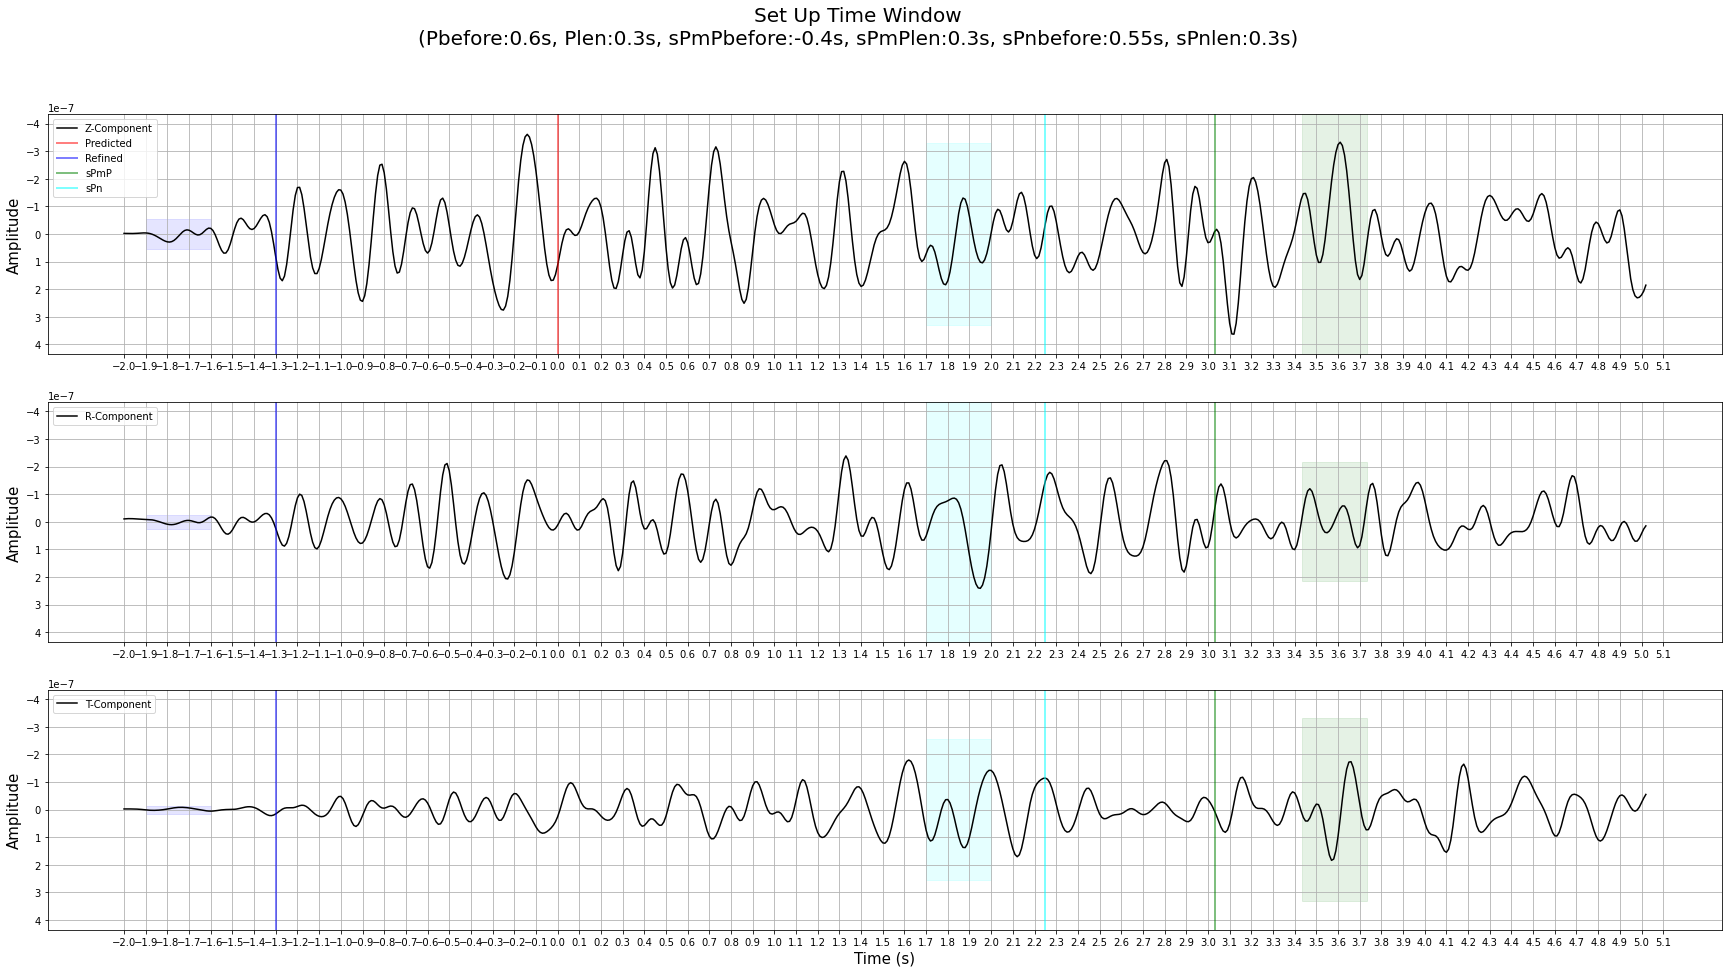

KeyboardInterrupt: Interrupted by user

In [16]:
### Check the event one by one
evtid =1

with open(f"{ddir}/judge.info","r") as files:
    #print("something")
    for i,file in enumerate(files):
        if i == evtid - 1:
            #print("something...")
            evt = file.split()[1]
            sta = file.split()[2]
            Tp = float(file.split()[4])
            TsPmP = float(file.split()[6])
            TsPn = float(file.split()[8])
            #print("TsPn: ", TsPn, type(TsPn))
            #print(float('nan'))

            inpath = os.path.join(data_sac, evt)
            os.chdir(inpath)
            print(glob.glob(f"{sta}*[RTZ].SAC.bp.cut"))

            st = obspy.read(f"{sta}*[RTZ].SAC.bp.cut")
            sachd = st[0].stats.sac
            print(st,sachd["evdp"],sachd["dist"])

        ### tune these parameters to set proper windows
            Tpbefore = 0.6
            Tplen = 0.3
            Tspnbefore = 0.55
            Tspnlen = 0.3
            Tspmbefore = -0.4
            Tspmlen = 0.3
            

            while 1:
                fig1 = set_window(st, Tp, TsPmP, TsPn, Twbefore=2, Twafter=2, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
                quality = input("Quality: y(good) or b(bad)")
                time.sleep(1)
                if quality == "y":
                    break 
                else:
                    
                    print("Redecide the time window\n")
                    os.sys.exit()
            
            

            fig2 = vef_amp(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig3 = vef_polaz(st, Tp, TsPmP, TsPn, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            fig4 = vef_sptm(st, Tp, TsPmP, TsPn, PN=2**8, Tpbefore=Tpbefore, Tplen=Tplen, Tspmbefore=Tspmbefore, Tspmlen=Tspmlen, Tspnbefore=Tspnbefore, Tspnlen=Tspnlen)
            print("check: 1. Vertical component, 2. Amplitude ratio, 3. Predominant period, 4. Direction")
            score = input("overall score: a(4 checks), b(3 checks), c(2 checks)")
            if not os.path.exists(f"{wdir}/{evt}"):
                os.mkdir(f"{wdir}/{evt}")
            if score == "a": 
                if not os.path.exists(f"{wdir}/{evt}/A"):
                    os.mkdir(f"{wdir}/{evt}/A")

                pdf = PdfPages(f"{wdir}/{evt}/A/{sta}_analyses.pdf")
            elif score == "b":
                if not os.path.exists(f"{wdir}/{evt}/B"):
                    os.mkdir(f"{wdir}/{evt}/B")

                pdf = PdfPages(f"{wdir}/{evt}/B/{sta}_analyses.pdf")
            elif score == 'c':
                if not os.path.exists(f"{wdir}/{evt}/C"):
                    os.mkdir(f"{wdir}/{evt}/C")

                pdf = PdfPages(f"{wdir}/{evt}/C/{sta}_analyses.pdf")
            
            pdf.savefig(fig1)
            pdf.savefig(fig2)
            pdf.savefig(fig3)
            pdf.savefig(fig4)
            pdf.close()
        #else: print("nothing happened")